In [116]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.nn import GCNConv

#########################################
# Use CUDA if available
#########################################

In [117]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


#########################################
# Step 1: Preprocess the BIWI Data
#########################################

In [118]:
# Load and clean data
df = pd.read_csv("ewap_dataset/seq_eth/obsmat.txt", delim_whitespace=True, header=None)
df = df[[0, 1, 2, 4, 5, 7]]
df.columns = ['time', 'agent_id', 'pos_x', 'pos_y', 'vel_x', 'vel_y']
df.sort_values('time', inplace=True)

/tmp/ipykernel_2241/1880969810.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("ewap_dataset/seq_eth/obsmat.txt", delim_whitespace=True, header=None)


In [119]:
# Normalize positions and velocities
scaler = MinMaxScaler()
df[['pos_x', 'pos_y', 'vel_x', 'vel_y']] = scaler.fit_transform(df[['pos_x', 'pos_y', 'vel_x', 'vel_y']])

In [120]:
# Group data by time: create a dictionary mapping each time step to {agent_id: feature tensor}
time_groups = df.groupby('time')
time_dict = {}
for t, group in time_groups:
    agents = group['agent_id'].values
    features = group[['pos_x', 'pos_y', 'vel_x', 'vel_y']].values
    feat_dict = {}
    for i, agent in enumerate(agents):
        # Features as tensor; moved to device later
        feat_dict[int(agent)] = torch.tensor(features[i], dtype=torch.float32)
    time_dict[t] = feat_dict

unique_times = sorted(time_dict.keys())

#########################################
# Step 2: Define a Dataset Class for Sliding Windows
#########################################

In [121]:
class BIWIDataset(Dataset):
    def __init__(self, time_dict, window_size, feature_dim):
        self.times = sorted(time_dict.keys())
        self.time_dict = time_dict
        self.window_size = window_size
        self.feature_dim = feature_dim
        
        # Create sliding windows over the sorted time steps
        self.windows = []
        for i in range(len(self.times) - window_size + 1):
            window_times = self.times[i : i + window_size]
            self.windows.append(window_times)
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        window_times = self.windows[idx]
        x_dict_list = []            # List of dictionaries (one per time step)
        edge_index_dict_list = []   # List of edge_index tensors (one per time step)
        
        # For each time step in the window, retrieve the agent feature dictionary
        for t in window_times:
            feat_dict = self.time_dict[t]
            x_dict_list.append(feat_dict)
            # Build a simple fully-connected edge index (excluding self-loops)
            agent_ids = list(feat_dict.keys())
            n_agents = len(agent_ids)
            if n_agents > 0:
                rows, cols = [], []
                for i in range(n_agents):
                    for j in range(n_agents):
                        if i != j:
                            rows.append(i)
                            cols.append(j)
                edge_index = torch.tensor([rows, cols], dtype=torch.long)
            else:
                edge_index = torch.empty((2, 0), dtype=torch.long)
            edge_index_dict_list.append(edge_index)
        
        # Construct ground truth tensor by padding across the window.
        # Compute union of all agent IDs in this window.
        all_agent_ids = set()
        for feat_dict in x_dict_list:
            all_agent_ids.update(feat_dict.keys())
        all_agent_ids = sorted(list(all_agent_ids))
        num_agents = len(all_agent_ids)
        # Ground truth: shape (window_size, num_agents, feature_dim)
        ground_truth = torch.zeros(len(x_dict_list), num_agents, self.feature_dim)
        for t, feat_dict in enumerate(x_dict_list):
            for idx, agent_id in enumerate(all_agent_ids):
                if agent_id in feat_dict:
                    ground_truth[t, idx] = feat_dict[agent_id]
        return x_dict_list, edge_index_dict_list, ground_truth

In [122]:
# Parameters for the dataset
window_size = 5          # number of consecutive time steps per sample
feature_dim = 4          # [pos_x, pos_y, vel_x, vel_y]
dataset = BIWIDataset(time_dict, window_size, feature_dim)

In [123]:
# Use a custom collate function to avoid unwanted dict aggregation
def collate_fn(batch):
    return batch[0]

In [124]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

#########################################
# Step 3: Define the Hybrid GNN+Transformer Model with a Decoder
#########################################

In [125]:
class SpatialGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(SpatialGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [126]:
class TemporalTransformer(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dropout=0.1):
        super(TemporalTransformer, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
    def forward(self, src, src_key_padding_mask=None):
        out = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)
        return out

In [127]:
class GNNTransformerVariableAgents(nn.Module):
    def __init__(self, spatial_in_dim, spatial_hidden_dim, transformer_dim, nhead, num_layers, output_dim):
        """
        Args:
          spatial_in_dim: Input feature dimension (4)
          spatial_hidden_dim: Hidden dimension for the GNN
          transformer_dim: Dimension for the Transformer (e.g., 32)
          nhead: Number of attention heads
          num_layers: Number of Transformer encoder layers
          output_dim: Desired output feature dimension (should match ground truth, e.g. 4)
        """
        super(GNNTransformerVariableAgents, self).__init__()
        self.spatial_gnn = SpatialGNN(spatial_in_dim, spatial_hidden_dim)
        self.linear = nn.Linear(spatial_hidden_dim, transformer_dim)
        self.transformer_dim = transformer_dim
        self.temporal_transformer = TemporalTransformer(transformer_dim, nhead, num_layers)
        # Decoder to map transformer output to desired feature dimension (e.g., 4)
        self.decoder = nn.Linear(transformer_dim, output_dim)
        
    def forward(self, x_dict_list, edge_index_dict_list):
        T = len(x_dict_list)
        spatial_outputs = []
        for t in range(T):
            feat_dict = x_dict_list[t]
            x = []
            agent_ids = []
            for agent_id, feat in feat_dict.items():
                # Move feature tensor to device
                x.append(feat.unsqueeze(0).to(device))
                agent_ids.append(agent_id)
            if len(x) > 0:
                x = torch.cat(x, dim=0)
            else:
                x = torch.empty((0, self.linear.in_features)).to(device)
            edge_index = edge_index_dict_list[t].to(device)
            if x.size(0) > 0:
                spatial_feat = self.spatial_gnn(x, edge_index)
                spatial_feat = self.linear(spatial_feat)
                feat_out = {agent_ids[i]: spatial_feat[i] for i in range(len(agent_ids))}
            else:
                feat_out = {}
            spatial_outputs.append(feat_out)
        
        # Padding: compute union of agent IDs across the window.
        all_agent_ids = set()
        for feat_dict in spatial_outputs:
            all_agent_ids.update(feat_dict.keys())
        all_agent_ids = sorted(list(all_agent_ids))
        num_agents = len(all_agent_ids)
        
        padded_features = torch.zeros(T, num_agents, self.transformer_dim).to(device)
        pad_mask = torch.ones(T, num_agents, dtype=torch.bool).to(device)
        
        for t in range(T):
            feat_dict = spatial_outputs[t]
            for idx, agent_id in enumerate(all_agent_ids):
                if agent_id in feat_dict:
                    padded_features[t, idx] = feat_dict[agent_id]
                    pad_mask[t, idx] = False
        
        # Transformer expects input shape: (sequence_length, batch_size, d_model)
        # Prepare key padding mask: shape (num_agents, T)
        src_key_padding_mask = pad_mask.transpose(0, 1)
        temporal_output = self.temporal_transformer(padded_features, src_key_padding_mask=src_key_padding_mask)
        # Apply the decoder to project to desired output dimension (e.g., 4)
        decoded_output = self.decoder(temporal_output)
        return decoded_output, all_agent_ids, src_key_padding_mask

In [128]:
# Set model hyperparameters
spatial_hidden_dim = 32
transformer_dim = 32
nhead = 4
num_layers = 2
learning_rate = 0.001
num_epochs = 10
output_dim = feature_dim  # This should match the ground truth dimension (4)

In [129]:
model = GNNTransformerVariableAgents(
    spatial_in_dim=feature_dim,
    spatial_hidden_dim=spatial_hidden_dim,
    transformer_dim=transformer_dim,
    nhead=nhead,
    num_layers=num_layers,
    output_dim=output_dim
).to(device)

/home/subhronil/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [130]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

#########################################
# Step 4: Training Loop with CUDA
#########################################

In [ ]:
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in dataloader:
        # Using custom collate_fn, batch is directly (x_dict_list, edge_index_dict_list, ground_truth)
        x_dict_list, edge_index_dict_list, ground_truth = batch
        ground_truth = ground_truth.to(device)
        
        optimizer.zero_grad()
        output, all_agent_ids, src_key_padding_mask = model(x_dict_list, edge_index_dict_list)
        # output shape is now (T, num_agents, output_dim) matching ground_truth
        loss = criterion(output, ground_truth)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Using device: cuda


/tmp/ipykernel_33721/2475574300.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("ewap_dataset/seq_eth/obsmat.txt", delim_whitespace=True, header=None)


/home/subhronil/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10, Loss: 0.0220
Epoch 2/10, Loss: 0.0156
Epoch 3/10, Loss: 0.0153
Epoch 4/10, Loss: 0.0150
Epoch 5/10, Loss: 0.0147
Epoch 6/10, Loss: 0.0146
Epoch 7/10, Loss: 0.0145
Epoch 8/10, Loss: 0.0147
Epoch 9/10, Loss: 0.0144
Epoch 10/10, Loss: 0.0143


In [131]:
import matplotlib.pyplot as plt

In [40]:
# After training, save a checkpoint.
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,  # you can save the loss if desired
}

torch.save(checkpoint, "trained_gnn_transformer_model.pth")
print("Model checkpoint saved.")

Model checkpoint saved.


In [132]:
# First, reinstantiate your model architecture.
# Make sure the hyperparameters here match what was used for training.
model = GNNTransformerVariableAgents(
    spatial_in_dim=feature_dim,
    spatial_hidden_dim=spatial_hidden_dim,
    transformer_dim=transformer_dim,
    nhead=nhead,
    num_layers=num_layers,
    output_dim=feature_dim  # should match ground truth dimension
).to(device)

In [133]:
# Load the checkpoint.
checkpoint = torch.load("trained_gnn_transformer_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # Optional if you need the optimizer state
loaded_epoch = checkpoint['epoch']
loaded_loss = checkpoint['loss']

# Set the model to evaluation mode.
model.eval()

print(f"Model loaded from epoch {loaded_epoch} with loss {loaded_loss:.4f}.")

Model loaded from epoch 10 with loss 0.0143.


/tmp/ipykernel_2241/2210220194.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("trained_gnn_transformer_model.pth", map_location=device)


Test MSE loss: 0.007397149223834276


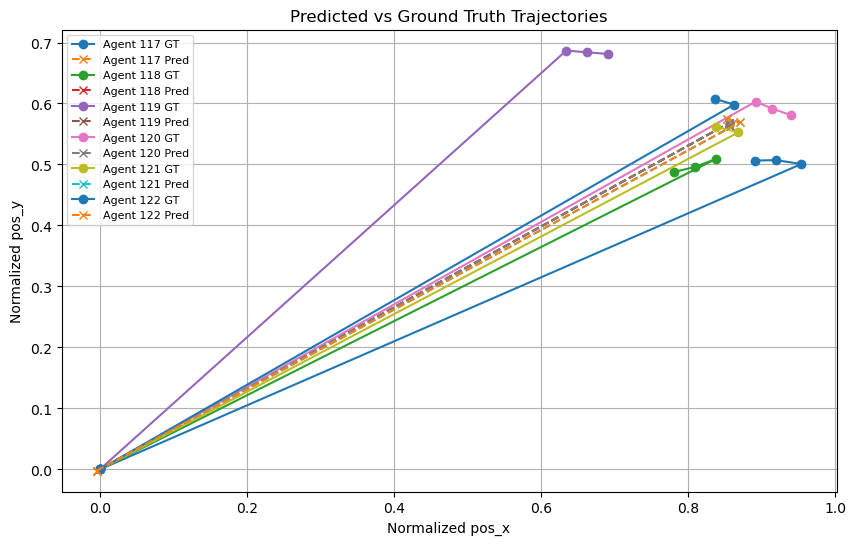

In [27]:
# Set the model to evaluation mode
model.eval()

# Inference and performance evaluation (using one sample from the dataloader)
with torch.no_grad():
    # Get one sample (using our custom collate, the sample remains in its original structure)
    sample = next(iter(dataloader))
    x_dict_list, edge_index_dict_list, ground_truth = sample
    # Move ground_truth to device
    ground_truth = ground_truth.to(device)
    
    # Forward pass through the model
    output, all_agent_ids, src_key_padding_mask = model(x_dict_list, edge_index_dict_list)
    
    # Compute Mean Squared Error loss (this is one measure of performance)
    mse_loss = criterion(output, ground_truth).item()
    print("Test MSE loss:", mse_loss)
    
    # Convert outputs and ground truth to numpy arrays for visualization
    # output and ground_truth shape: (T, num_agents, feature_dim)
    T, num_agents, _ = output.shape
    gt_np = ground_truth.cpu().numpy()
    pred_np = output.cpu().numpy()
    
# Visualization: Plot predicted versus ground truth trajectories (positions only)
plt.figure(figsize=(10, 6))
for agent_idx in range(num_agents):
    # Extract positions (first two features: pos_x and pos_y)
    gt_traj = gt_np[:, agent_idx, :2]
    pred_traj = pred_np[:, agent_idx, :2]
    
    # Plot ground truth trajectory with circles and a solid line
    plt.plot(gt_traj[:, 0], gt_traj[:, 1], "o-", label=f"Agent {all_agent_ids[agent_idx]} GT")
    # Plot predicted trajectory with x-markers and a dashed line
    plt.plot(pred_traj[:, 0], pred_traj[:, 1], "x--", label=f"Agent {all_agent_ids[agent_idx]} Pred")

plt.title("Predicted vs Ground Truth Trajectories")
plt.xlabel("Normalized pos_x")
plt.ylabel("Normalized pos_y")
plt.legend(loc="best", fontsize=8)
plt.grid(True)
plt.show()

In [30]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Recreate optimizer if needed

In [31]:
import torch
import matplotlib.pyplot as plt

In [32]:
# Initialize accumulators for metrics
total_mse = 0.0
total_ade = 0.0  # Average displacement error over all time steps and agents
total_fde = 0.0  # Final displacement error (last time step)
num_samples_eval = 0

In [33]:
# Set the model to evaluation mode
model.eval()

# We'll evaluate on the same dataloader (you could also create a dedicated validation/test dataloader)
with torch.no_grad():
    for batch in dataloader:
        # Using our custom collate_fn, batch is (x_dict_list, edge_index_dict_list, ground_truth)
        x_dict_list, edge_index_dict_list, ground_truth = batch
        ground_truth = ground_truth.to(device)
        
        # Forward pass through the model
        output, all_agent_ids, src_key_padding_mask = model(x_dict_list, edge_index_dict_list)
        # output shape: (T, num_agents, output_dim) where output_dim should match ground truth (e.g., 4)

        # Compute MSE loss using the same criterion
        mse = criterion(output, ground_truth).item()

        # Assume that the first two features are the (pos_x, pos_y) positions
        # Extract positions from predicted output and ground truth.
        pred_positions = output[..., :2]  # shape: (T, num_agents, 2)
        true_positions = ground_truth[..., :2]  # shape: (T, num_agents, 2)

        # Compute Euclidean distance error for each time step and each agent
        # errors: shape (T, num_agents)
        errors = torch.norm(pred_positions - true_positions, dim=2)

        # ADE: Mean error over all time steps and agents
        ade = errors.mean().item()

        # FDE: Mean error at the final time step (last frame)
        fde = errors[-1].mean().item()

        total_mse += mse
        total_ade += ade
        total_fde += fde
        num_samples_eval += 1

In [34]:
# Average metrics over the evaluation samples
avg_mse = total_mse / num_samples_eval
avg_ade = total_ade / num_samples_eval
avg_fde = total_fde / num_samples_eval

In [35]:
print("Evaluation Metrics:")
print(f"  MSE: {avg_mse:.4f}")
print(f"  ADE: {avg_ade:.4f}")
print(f"  FDE: {avg_fde:.4f}")

Evaluation Metrics:
  MSE: 0.0140
  ADE: 0.1325
  FDE: 0.1325


# -------------------------------
# Visualization for a single sample
# -------------------------------

Evaluation Metrics:
  MSE: 0.0140
  ADE: 0.1325
  FDE: 0.1325


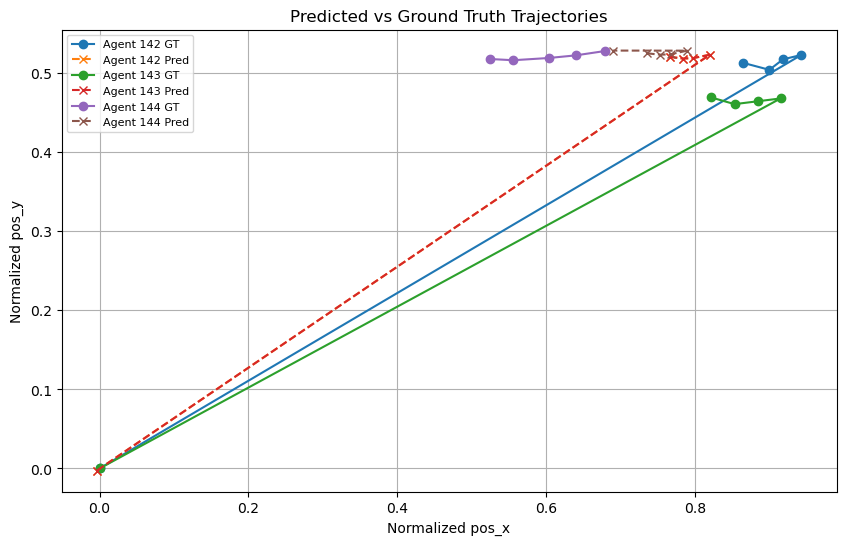

In [ ]:

# We visualize one sample from the evaluation set.
with torch.no_grad():
    sample = next(iter(dataloader))
    x_dict_list, edge_index_dict_list, ground_truth = sample
    ground_truth = ground_truth.to(device)
    
    output, all_agent_ids, src_key_padding_mask = model(x_dict_list, edge_index_dict_list)
    # Convert to numpy arrays (move to CPU)
    gt_np = ground_truth.cpu().numpy()  # shape: (T, num_agents, feature_dim)
    pred_np = output.cpu().numpy()      # shape: (T, num_agents, feature_dim)
    
    T, num_agents, _ = output.shape
    
    plt.figure(figsize=(10, 6))
    for agent_idx in range(num_agents):
        # Extract the predicted and ground truth positions (first two features)
        gt_traj = gt_np[:, agent_idx, :2]
        pred_traj = pred_np[:, agent_idx, :2]
        
        # Plot ground truth trajectory (solid line with circles)
        plt.plot(gt_traj[:, 0], gt_traj[:, 1], "o-", label=f"Agent {all_agent_ids[agent_idx]} GT")
        # Plot predicted trajectory (dashed line with x-markers)
        plt.plot(pred_traj[:, 0], pred_traj[:, 1], "x--", label=f"Agent {all_agent_ids[agent_idx]} Pred")
    
    plt.title("Predicted vs Ground Truth Trajectories")
    plt.xlabel("Normalized pos_x")
    plt.ylabel("Normalized pos_y")
    plt.legend(loc="best", fontsize=8)
    plt.grid(True)
    plt.show()


# RL MODEL TRAINING

In [134]:
import gym
import numpy as np
import torch
from gym import spaces
import cv2
import random

-------------------------------
Environment with Destination and Obstacle Constraints
-------------------------------

In [135]:
class CrowdSimEnvWithBoundaries(gym.Env):
    """
    This environment uses a pre-trained GNN+Transformer model to predict pedestrian positions.
    It then sets a random destination (from destinations.txt) as the goal and checks for collisions
    with obstacles derived from map.png using a homography matrix (H.txt). The agent's state (agent position
    and predicted pedestrian positions) and actions are in world coordinates.
    """
    metadata = {"render.modes": ["human"]}
    
    def __init__(self, model, pedestrian_data, pos_min, pos_max, destinations_file, map_file, homography_file,
                 max_steps=50, max_agents=6):
        """
        Args:
          model: Pre-trained GNN+Transformer model (trained on normalized coordinates).
          pedestrian_data: List of samples from your BIWIDataset.
          pos_min: 2D vector [min_x, min_y] from the original MinMaxScaler.
          pos_max: 2D vector [max_x, max_y] from the original MinMaxScaler.
          destinations_file: Path to destinations.txt.
          map_file: Path to map.png.
          homography_file: Path to H.txt.
          max_steps: Maximum steps per episode.
          max_agents: Fixed number of pedestrian agents in the observation.
        """
        super(CrowdSimEnvWithBoundaries, self).__init__()
        self.model = model
        self.model.eval()
        self.pos_min = pos_min  # world coordinate minimum (e.g., from original data)
        self.pos_max = pos_max  # world coordinate maximum
        self.max_steps = max_steps
        self.max_agents = max_agents
        
        # Load destinations (each row: [x, y]) in world coordinates.
        self.destinations = np.loadtxt(destinations_file)  # shape (num_destinations, 2)
        self.goal = None  # to be selected in reset()
        
        # Load obstacle map image (grayscale) and homography matrix.
        self.map_img = cv2.imread(map_file, cv2.IMREAD_GRAYSCALE)
        if self.map_img is None:
            raise RuntimeError("Failed to load map image")
        self.H = np.loadtxt(homography_file)  # 3x3 matrix
        
        # pedestrian_data: list of samples as (x_dict_list, edge_index_dict_list, ground_truth)
        self.pedestrian_data = pedestrian_data
        
        # Observation: agent position (2D) plus predicted pedestrian positions (max_agents x 2).
        # Here, both agent and pedestrian positions are in world coordinates.
        self.obs_dim = 2 + self.max_agents * 2
        # Define observation space using known world bounds.
        low_obs = np.concatenate([self.pos_min, np.tile(self.pos_min, self.max_agents)])
        high_obs = np.concatenate([self.pos_max, np.tile(self.pos_max, self.max_agents)])
        self.observation_space = spaces.Box(low=low_obs, high=high_obs, dtype=np.float32)
        
        # Action: 2D velocity command in world units.
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(2,), dtype=np.float32)
        
        # Internal variables
        self.current_sample = None
        self.x_dict_list = None
        self.edge_index_dict_list = None
        self.ground_truth = None
        self.predicted_pedestrians = None  # in world coordinates
        self.agent_pos = None  # in world coordinates
        self.current_step = 0
        
        self.reset()
    
    def denormalize(self, norm_pos):
        """
        Convert normalized position (in [0,1]) to world coordinates using pos_min and pos_max.
        """
        return self.pos_min + norm_pos * (self.pos_max - self.pos_min)
    
    def is_in_obstacle(self, world_pos, threshold=100):
        """
        Check if the given world coordinate is inside an obstacle.
        The world coordinate is transformed to pixel coordinates using the homography matrix.
        """
        point = np.array([world_pos[0], world_pos[1], 1.0])
        p = self.H @ point
        p = p / p[2]
        px = int(round(p[0]))
        py = int(round(p[1]))
        h, w = self.map_img.shape
        if px < 0 or px >= w or py < 0 or py >= h:
            return False  # outside map: assume free space
        return self.map_img[py, px] < threshold  # obstacles assumed to be dark
    
    def reset(self):
        # Choose a random pedestrian sample from the dataset.
        self.current_sample = random.choice(self.pedestrian_data)
        self.x_dict_list, self.edge_index_dict_list, self.ground_truth = self.current_sample
        
        # Use the pre-trained model to predict pedestrian positions for the first time step.
        with torch.no_grad():
            output, all_agent_ids, src_key_padding_mask = self.model(self.x_dict_list, self.edge_index_dict_list)
            # output shape: (T, num_agents, output_dim); take time 0, first 2 dims (normalized positions).
            pred_norm = output[0, :, :2].cpu().numpy()  # shape: (n_agents, 2)
        
        # Denormalize pedestrian positions to world coordinates.
        pred_world = self.denormalize(pred_norm)
        n_agents = pred_world.shape[0]
        if n_agents < self.max_agents:
            pad_width = self.max_agents - n_agents
            padded_pred = np.concatenate([pred_world, np.zeros((pad_width, 2))], axis=0)
        else:
            padded_pred = pred_world[:self.max_agents]
        self.predicted_pedestrians = padded_pred  # shape: (max_agents, 2)
        
        # Set the agent's starting position. Here, we choose the center of the scene.
        self.agent_pos = (self.pos_min + self.pos_max) / 2.0
        
        # Randomly select a destination from the loaded destinations.
        self.goal = random.choice(self.destinations)
        
        self.current_step = 0
        
        obs = np.concatenate([self.agent_pos, self.predicted_pedestrians.flatten()])
        return obs.astype(np.float32)
    
    def step(self, action):
        action = np.clip(action, self.action_space.low, self.action_space.high)
        # Update the agent's position using simple Euler integration.
        self.agent_pos = self.agent_pos + action

        # Build observation.
        obs = np.concatenate([self.agent_pos, self.predicted_pedestrians.flatten()])

        # Initialize reward.
        reward = 0.0

        # 1. Per-step reward for staying inside the allowed area.
        # Here we give a small positive reward if the agent is within the boundaries.
        if (self.agent_pos[0] >= self.pos_min[0] and self.agent_pos[0] <= self.pos_max[0] and
            self.agent_pos[1] >= self.pos_min[1] and self.agent_pos[1] <= self.pos_max[1]):
            reward += 0.1  # Small reward for being inside
        else:
            reward -= 0.5  # Penalty for leaving the allowed area

        # 2. Collision penalty: subtract if the agent is too close to any pedestrian.
        collision_threshold = 0.5  # Adjust as needed (in world units)
        for ped in self.predicted_pedestrians:
            if np.linalg.norm(self.agent_pos - ped) < collision_threshold:
                reward -= 1.0  # Penalty for collision

        # 3. Goal bonus: if the agent is close enough to the goal, provide a large positive reward and end the episode.
        dist_to_goal = np.linalg.norm(self.agent_pos - self.goal)
        if dist_to_goal < 1.0:  # If within 1 world unit of the goal.
            reward += 20.0  # Large bonus for reaching the goal.
            done = True
        else:
            done = False

        # End the episode if maximum steps are reached.
        self.current_step += 1
        if self.current_step >= self.max_steps:
            done = True

        return obs.astype(np.float32), reward, done, {}

-------------------------------
Example Setup and PPO Integration
-------------------------------

In [136]:
# Define world bounds (from the original scaler, adjust these as needed)
pos_min = np.array([-20.0, 0.0], dtype=np.float32)
pos_max = np.array([15.0, 12.0], dtype=np.float32)

In [137]:
# File paths for destinations, map, and homography matrix.
destinations_file = "ewap_dataset/seq_eth/destinations.txt"
map_file = "ewap_dataset/seq_eth/map.png"
homography_file = "ewap_dataset/seq_eth/H.txt"

In [138]:
# Assume 'dataset' is your BIWIDataset instance created earlier.
pedestrian_data = [dataset[i] for i in range(len(dataset))]

In [139]:
# Create the environment with boundaries.
env_bound = CrowdSimEnvWithBoundaries(model, pedestrian_data, pos_min, pos_max,
                                       destinations_file, map_file, homography_file,
                                       max_steps=50, max_agents=6)

In [140]:
# Create and train a PPO agent on the new environment.
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3 import PPO

In [141]:
# Wrap your environment in a DummyVecEnv
env = DummyVecEnv([lambda: env_bound])  # env_bound is your CrowdSimEnvWithBoundaries instance

# Normalize observations and rewards
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

/home/subhronil/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [142]:
# Adjust PPO hyperparameters (for example, lowering vf_coef and using a lower learning rate)
ppo_agent_bound = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    vf_coef=0.3,            # Adjusted value function coefficient
    learning_rate=0.0002,   # Possibly lower learning rate for stability
)

Using cuda device


/home/subhronil/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [113]:
# Train the PPO agent
ppo_agent_bound.learn(total_timesteps=20000)
ppo_agent_bound.save("ppo_crowd_sim_agent_bound_normalized")

-----------------------------
| time/              |      |
|    fps             | 229  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 187          |
|    iterations           | 2            |
|    time_elapsed         | 21           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0077979686 |
|    clip_fraction        | 0.0569       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | -0.122       |
|    learning_rate        | 0.0002       |
|    loss                 | 0.131        |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00785     |
|    std                  | 0.994        |
|    value_loss           | 1.05         |
----------------

In [143]:
from stable_baselines3 import PPO

# Load the saved model (make sure to set the appropriate device)
model_PPO = PPO.load("ppo_crowd_sim_agent_bound_normalized", device="cuda" if torch.cuda.is_available() else "cpu")

In [145]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# Create your evaluation environment; if you used wrappers during training, use them here too.
eval_env = DummyVecEnv([lambda: env_bound])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=True, clip_obs=10.)

# Run evaluation over a number of episodes (for example, 10 episodes)
mean_reward, std_reward = evaluate_policy(model_PPO, eval_env, n_eval_episodes=10, deterministic=True)
print("Mean reward:", mean_reward, "Std reward:", std_reward)

Mean reward: 6.7932840649038555 Std reward: 6.347755447159998


In [115]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# Create your evaluation environment; if you used wrappers during training, use them here too.
eval_env = DummyVecEnv([lambda: env_bound])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=True, clip_obs=10.)

# Run evaluation over a number of episodes (for example, 10 episodes)
mean_reward, std_reward = evaluate_policy(model_PPO, eval_env, n_eval_episodes=10, deterministic=True)
print("Mean reward:", mean_reward, "Std reward:", std_reward)

/home/subhronil/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: 5.512469575554133 Std reward: 6.056536853829087


In [91]:
import cv2
import numpy as np

In [92]:
# Define a helper function to convert world coordinates to pixel coordinates using H
def world_to_pixel(world_pos, H):
    """
    Converts a 2D world coordinate to pixel coordinate using the homography matrix.
    
    Args:
      world_pos: numpy array or list with two elements [x, y] in world coordinates.
      H: 3x3 homography matrix.
      
    Returns:
      (px, py): Pixel coordinates as integers.
    """
    point = np.array([world_pos[0], world_pos[1], 1.0])
    p = H @ point
    p = p / p[2]
    return int(round(p[0])), int(round(p[1]))

In [ ]:
# Open the video file.
video_path = "ewap_dataset/seq_eth/seq_eth.avi"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError("Unable to open video file.")

In [93]:
# Reset the environment and get the initial observation.
obs = env_bound.reset()  # env_bound is your CrowdSimEnvWithBoundaries instance
done = False

In [ ]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # End of video.

    # If the episode ended, reset the environment.
    if done:
        obs = env_bound.reset()
        done = False

    # Get an action from the trained PPO agent.
    action, _ = ppo_agent_bound.predict(obs)
    obs, reward, done, info = env_bound.step(action)
    
    # Extract simulation state (world coordinates).
    agent_pos = env_bound.agent_pos      # Agent's position.
    goal = env_bound.goal                # Goal position.
    ped_positions = env_bound.predicted_pedestrians  # Predicted pedestrian positions (shape: (max_agents, 2)).
    
    # Convert world coordinates to pixel coordinates using the homography matrix.
    agent_px, agent_py = world_to_pixel(agent_pos, env_bound.H)
    goal_px, goal_py = world_to_pixel(goal, env_bound.H)
    ped_pixels = [world_to_pixel(ped, env_bound.H) for ped in ped_positions]
    
    # Overlay the simulation state on the video frame.
    cv2.circle(frame, (agent_px, agent_py), 10, (0, 0, 255), -1)   # Agent in red.
    cv2.circle(frame, (goal_px, goal_py), 10, (0, 255, 0), -1)       # Goal in green.
    for (px, py) in ped_pixels:
        cv2.circle(frame, (px, py), 8, (255, 0, 0), -1)             # Pedestrians in blue.
    
    # Optionally, add text to show the current simulation step.
    cv2.putText(frame, f"Step: {env_bound.current_step}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    
    # Display the frame.
    cv2.imshow("Simulation on Video", frame)
    
    # Wait for 100ms between frames (adjust to slow down/speed up).
    if cv2.waitKey(100) & 0xFF == 27:  # Press ESC to exit.
        break

cap.release()
cv2.destroyAllWindows()


QObject::moveToThread: Current thread (0x3e15dda0) is not the object's thread (0x234be1a0).
Cannot move to target thread (0x3e15dda0)

QObject::moveToThread: Current thread (0x3e15dda0) is not the object's thread (0x234be1a0).
Cannot move to target thread (0x3e15dda0)

QObject::moveToThread: Current thread (0x3e15dda0) is not the object's thread (0x234be1a0).
Cannot move to target thread (0x3e15dda0)

QObject::moveToThread: Current thread (0x3e15dda0) is not the object's thread (0x234be1a0).
Cannot move to target thread (0x3e15dda0)

QObject::moveToThread: Current thread (0x3e15dda0) is not the object's thread (0x234be1a0).
Cannot move to target thread (0x3e15dda0)

QObject::moveToThread: Current thread (0x3e15dda0) is not the object's thread (0x234be1a0).
Cannot move to target thread (0x3e15dda0)

QObject::moveToThread: Current thread (0x3e15dda0) is not the object's thread (0x234be1a0).
Cannot move to target thread (0x3e15dda0)

QObject::moveToThread: Current thread (0x3e15dda0) is n

In [97]:
import cv2
import numpy as np
import random

def world_to_pixel(world_pos, H):
    """
    Convert a 2D world coordinate to pixel coordinate using the homography matrix.
    """
    point = np.array([world_pos[0], world_pos[1], 1.0])
    p = H @ point
    p = p / p[2]
    return int(round(p[0])), int(round(p[1]))

# Load video, homography matrix, and destination points.
# video_path = "seq_eth.avi"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError("Unable to open video file.")

H = np.loadtxt("ewap_dataset/seq_eth/H.txt")  # Homography matrix (3x3)
destinations = np.loadtxt("ewap_dataset/seq_eth/destinations.txt")  # Each row: [x, y] in world coordinates
print("Loaded destinations:\n", destinations)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    # Choose a random destination point from the list.
    random_dest = random.choice(destinations)
    dest_px, dest_py = world_to_pixel(random_dest, H)

    # Draw a green circle at the destination point.
    cv2.circle(frame, (dest_px, dest_py), 10, (0, 255, 0), -1)
    cv2.putText(frame, "Dest", (dest_px+10, dest_py), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    cv2.imshow("Test Destination Overlay", frame)
    key = cv2.waitKey(100)  # 100ms delay between frames; adjust as needed.
    if key == 27:  # ESC key to exit.
        break

cap.release()
cv2.destroyAllWindows()


Loaded destinations:
 [[-20.           5.8566027 ]
 [ -6.5902743    0.06572437]
 [ -6.5553084   11.867515  ]
 [ 15.107171     5.5659299 ]]


QObject::moveToThread: Current thread (0x3e15dda0) is not the object's thread (0x234be1a0).
Cannot move to target thread (0x3e15dda0)

QObject::moveToThread: Current thread (0x3e15dda0) is not the object's thread (0x234be1a0).
Cannot move to target thread (0x3e15dda0)

QObject::moveToThread: Current thread (0x3e15dda0) is not the object's thread (0x234be1a0).
Cannot move to target thread (0x3e15dda0)

QObject::moveToThread: Current thread (0x3e15dda0) is not the object's thread (0x234be1a0).
Cannot move to target thread (0x3e15dda0)

QObject::moveToThread: Current thread (0x3e15dda0) is not the object's thread (0x234be1a0).
Cannot move to target thread (0x3e15dda0)

QObject::moveToThread: Current thread (0x3e15dda0) is not the object's thread (0x234be1a0).
Cannot move to target thread (0x3e15dda0)

QObject::moveToThread: Current thread (0x3e15dda0) is not the object's thread (0x234be1a0).
Cannot move to target thread (0x3e15dda0)

QObject::moveToThread: Current thread (0x3e15dda0) is n